In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [6]:
def m_gate(V):

    alpha_m = (15.0816 + 0.32*V)/(1 - 0.0089778037307*np.exp(-0.1*V))
    beta_m = 0.08*np.exp(-0.0909090909091*V)

    return alpha_m, beta_m


In [7]:
V = np.linspace(-80,40,1001);

In [8]:
alpha_m, beta_m = m_gate(V)

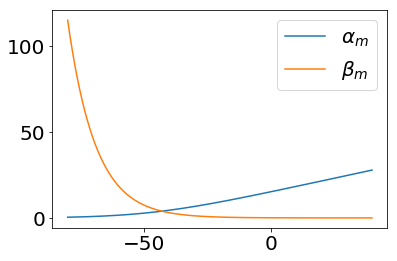

In [9]:
plt.plot(V,alpha_m,V,beta_m); plt.legend((r'$\alpha_m$',r'$\beta_m$')); plt.show()

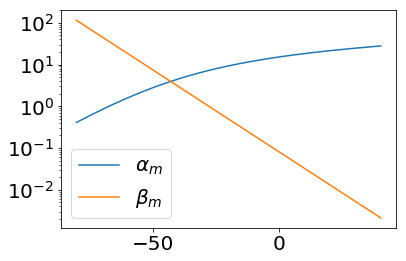

In [10]:
plt.semilogy(V,alpha_m,V,beta_m); plt.legend((r'$\alpha_m$',r'$\beta_m$')); plt.show()

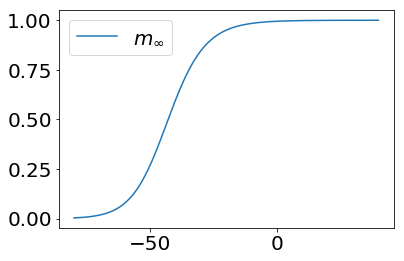

In [11]:
m_inf = alpha_m/(alpha_m+beta_m)
plt.plot(V, m_inf); plt.legend((r'$m_{\infty}$',)); plt.show()

In [12]:
def m_ode(m, t, V):

    alpha_m, beta_m = m_gate(V)
    dm = alpha_m*(1-m) - m*beta_m;

    return dm;




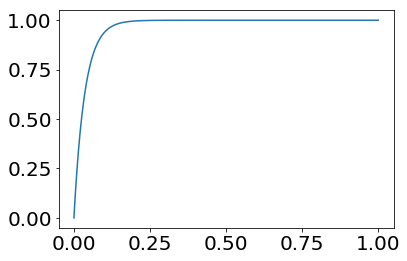

In [13]:
from scipy.integrate import odeint
T = np.linspace(0,1,1001);
m0 = 0;
V_hold = 40; 
m = odeint(m_ode, m0, T, (V_hold,))
plt.plot(T,m); plt.show()
# the gates open whth V = +40mV

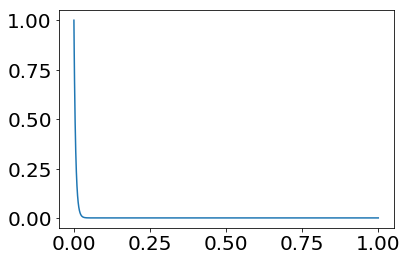

In [14]:
m0 = 1;
V_hold = -85; 
m = odeint(m_ode, m0, T, (V_hold,))
plt.plot(T,m); plt.show()
# the gate closes at V = -85mV

In [15]:
# making a model with gated sodium current
from math import log, exp

R = 8314 # mJ/(K mol)
T = 273.0+37.0 #  K
F = 96485.33289 # C/mol

K_o = 5.4;   #mM # try changing the K_o, check the effect on the solution
K_i = 145.0; #mM
E_K = (R*T/F)*log(K_o/K_i) # mV
g_K = 0.1; 

def i_K(V):

    i_K = g_K*(V-E_K);
    return i_K;




# Make a more realistic I_Na current, where the conductance is voltage depedendet
Na_o = 140.0
Na_i = 18.0;
E_Na = (R*T/F)*log(Na_o/Na_i) # mV
g_Na = 0.1;


def i_Na(V):
    alpha_m, beta_m = m_gate(V)
    m_inf = alpha_m/(alpha_m+beta_m)
    i_Na = g_Na*m_inf*(V-E_Na);
    return i_Na;



In [16]:
# define a membrane model that uses this currrent
def rhs(y, t, i_app):
    
    V = y;

    C_m = 1.0; # uF/cm^2

    if t>1:
        i_app = 0;

    i_ion = i_K(V) + i_Na(V);
    
    dV = -(1/C_m)*(i_ion + i_app);

    return dV;



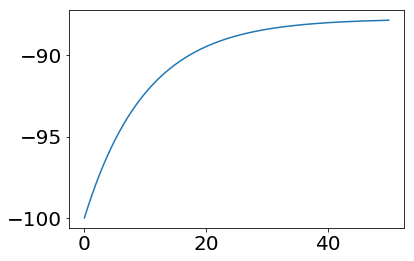

[-87.84398893]


In [17]:
# What is the equilibrium potential for this model?
# Lets solve untill steady state and find out:
from scipy.integrate import odeint
time = np.linspace(0,50,10001);
i_app = 0; 
P = (i_app,)
Y = odeint(rhs, -100, time, P)
plt.plot(time,Y); plt.show()
print(Y[-1])

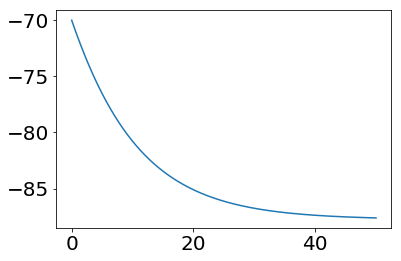

[-87.61137392]


In [18]:
Y = odeint(rhs, -70, time, P)
plt.plot(time,Y); plt.show()
print(Y[-1])

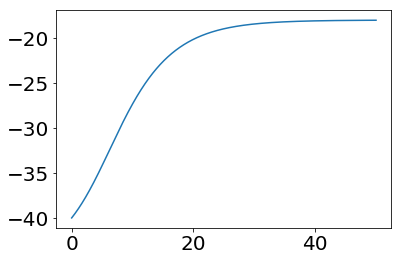

[-18.02384705]


In [19]:
Y = odeint(rhs, -40, time, P) 
plt.plot(time,Y); plt.show()
print(Y[-1])
# Here we got a very different answere

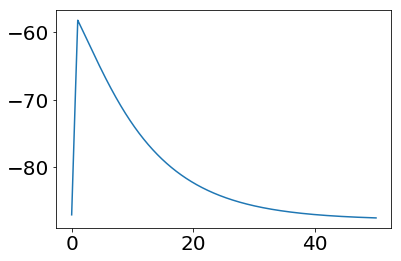

In [20]:
# how large must the applied current be in order to reach the higher potential?
Y = odeint(rhs, -87, time, (-30,))
plt.plot(time,Y); plt.show()

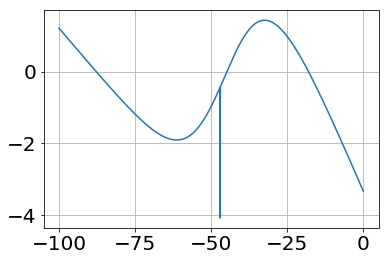

In [21]:
# plot the rhs as a function of voltage
V = np.linspace(-100,0,10001); # V = -47.13 not a good number...
dV = rhs(V, 0, 0)
plt.plot(V, dV); plt.grid(); plt.show()

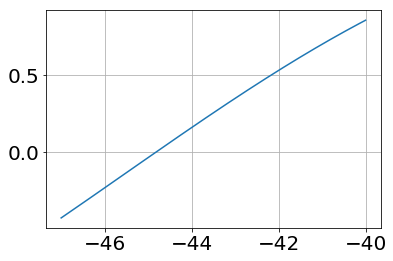

In [22]:
#zooming in around the unstable equilibrium
V = np.linspace(-47,-40,10001);
dV = rhs(V, 0, 0)
plt.plot(V, dV); plt.grid(); plt.show()
# The threshold seem to be about V=-45mV

In [23]:
# In a real action potential the membrane potential goes up after a sufficently strong stimulus (check)
# and the comes down again to the initial resting potential (currently not in place)


In [24]:
# The cell repolarzes because the sodium conductance is reduced, thus making the equilbrium potential closer to E_K
# This reduction is called inactivation, and is modeled by a different gate
def h_gate(V):
    
    if type(V)==np.ndarray:
        alpha_h = 0*V
        idx = np.nonzero(V<-40)
        alpha_h = 0*V
        alpha_h[idx] = 1.04951082543e-06*np.exp(-0.147058823529*V[idx])
        beta_h = (1.0/(0.13 + 0.0497581410839*np.exp(-0.0900900900901*V)));
        beta_h[idx] = 310000.0*np.exp(0.35*V[idx]) + 3.56*np.exp(0.079*V[idx])
    else:
        alpha_h = (0 if V >= -40 else 1.04951082543e-06*exp(-0.147058823529*V))
        beta_h = (1.0/(0.13 + 0.0497581410839*exp(-0.0900900900901*V)) if V >= -40 else 310000.0*exp(0.35*V) + 3.56*exp(0.079*V))
        
    return alpha_h, beta_h    


In [25]:
h_gate(-70)

(0.03102168708005281, 0.014126019335185692)

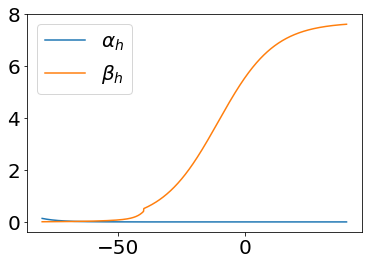

In [26]:
V = np.linspace(-80,40,1001);
alpha_h, beta_h = h_gate(V)
plt.plot(V,alpha_h,V,beta_h); plt.legend((r'$\alpha_h$',r'$\beta_h$')); plt.show()

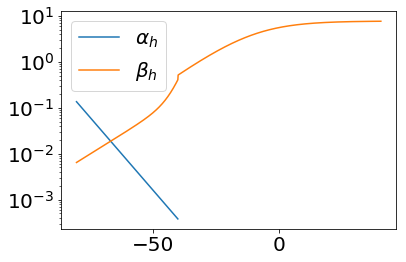

In [27]:
plt.semilogy(V,alpha_h,V,beta_h); plt.legend((r'$\alpha_h$',r'$\beta_h$')); plt.show()

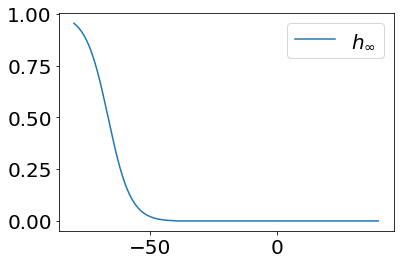

In [28]:
h_inf = alpha_h/(alpha_h+beta_h)
plt.plot(V, h_inf); plt.legend((r'$h_{\infty}$',)); plt.show()
# the h-gate behaves oposite of the m-gate, it closes at positive potentials

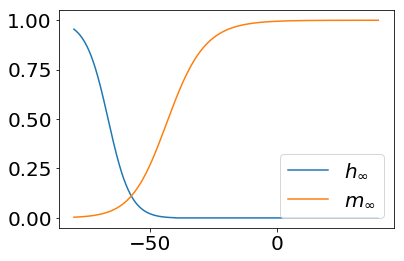

In [29]:
alpha_m, beta_m = m_gate(V)
m_inf = alpha_m/(alpha_m+beta_m)
plt.plot(V, h_inf,V,m_inf); plt.legend((r'$h_{\infty}$',r'$m_{\infty}$')); plt.show()

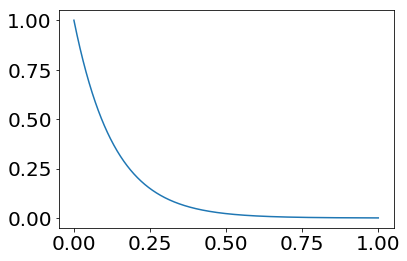

In [30]:
def h_ode(h, t, V):

    alpha_h, beta_h = h_gate(V)
    dh = alpha_h*(1-h) - h*beta_h;

    return dh;


from scipy.integrate import odeint
T = np.linspace(0,1,1001);
h0 = 1;
V_hold = +40; 
h = odeint(h_ode, h0, T, (V_hold,))
plt.plot(T,h); plt.show()

In [31]:
m0 = 0;
m = odeint(m_ode, m0, T, (V_hold,))

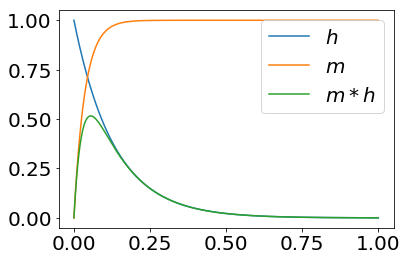

In [32]:
plt.plot(T,h,T,m,T,m*h); plt.legend((r'$h$',r'$m$',r'$m*h$')); plt.show()

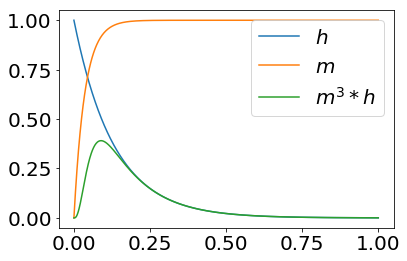

In [33]:
plt.plot(T,h,T,m,T,pow(m,3)*h); plt.legend((r'$h$',r'$m$',r'$m^3*h$')); plt.show()
# the gating of the sodium channel is often on the form m^3*h